## First Visit Monte Carlo Control with $\epsilon$ soft policies

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

from gridworld import GridWorld,plot_value,plot_policy
import numpy as np

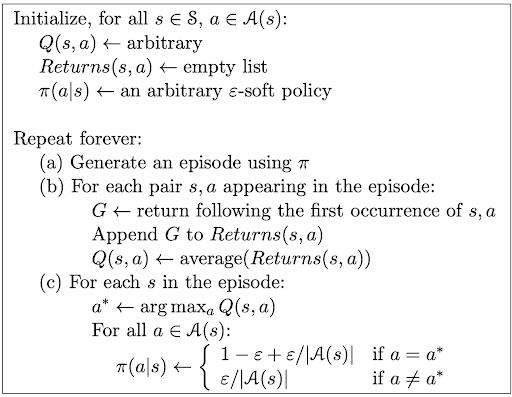

In [2]:
def generate_episode(Pi,size):
    '''
    play an episode on given policy and return G on state-action pairs
    
    Return a dictionary where k is (s,a), value is summation of all rewards after first visit
    '''
    
    env = GridWorld(size)
    done = False
    G = {} #episode reward
    while not done:
        #current_state
        current_state = env.agent_position.copy()
        
        #get action and step
        action_prob = Pi[tuple(current_state)] #
        action = np.random.choice(range(len(action_prob)),p = action_prob)
        next_state, reward, done, info = env.step(action)
        
        #append reward to all visited state-action pairs
        if (tuple(current_state),action) in G:
            G = {k:v+reward for k,v in G.items()}
        else:
            G[(tuple(current_state),action)] = 0
            G = {k:v+reward for k,v in G.items()}
    
    return G

In [3]:
#TEST
size = 4
Pi = dict.fromkeys([(i,j) for i in range(size) for j in range(size) if i+j != 0 and i+j != (size-1)*2], [0.25]*4)# inital actions as UP

generate_episode(Pi,size)

{((2, 3), 3): -21,
 ((2, 3), 0): -20,
 ((1, 3), 3): -19,
 ((1, 3), 2): -18,
 ((1, 3), 0): -15,
 ((0, 3), 2): -14,
 ((0, 3), 1): -12,
 ((0, 2), 0): -11,
 ((0, 2), 2): -10,
 ((1, 2), 0): -9,
 ((0, 2), 3): -8,
 ((0, 3), 3): -7,
 ((1, 3), 1): -4,
 ((1, 2), 2): -3,
 ((2, 2), 2): -2,
 ((3, 2), 2): -1,
 ((3, 2), 3): 0}

In [4]:
def MC_control_on_policy(Pi,size,iter_num, epsilon = 0.4):

    '''
    on-policy ﬁrst-visit MC control algorithm for ε-soft policies
    '''
    Q = {k:0 for k in [((i,j),a) for i in range(size) for j in range(size) for a in range(4)]}
    Returns = {k:[] for k in [((i,j),a) for i in range(size) for j in range(size) for a in range(4)]}
    
    
    for _ in range(iter_num):

        G = generate_episode(Pi,size)
        
        seen_states = set()
        
        #update Q
        for seen_pair in G:
            seen_states.add(seen_pair[0])
            
            Returns[seen_pair].append(G[seen_pair])
            
            #average returns and update V
            Q[seen_pair] = round(sum(Returns[seen_pair])/len(Returns[seen_pair]),3)
        
        #policy improvement
        for state in seen_states:
            action_values = [v for k,v in Q.items() if k[0] == state]
            best_action = np.argmax(action_values)
            Pi[state] = [1-epsilon+epsilon/4 if i == best_action else epsilon/4 for i in range(4)]  
    
    return Pi,Q

In [5]:
size = 6
Pi = dict.fromkeys([(i,j) for i in range(size) for j in range(size) if i+j != 0 and i+j != (size-1)*2], [0.25]*4)# inital actions as UP

In [6]:
Pi_final,Q = MC_control_on_policy(Pi,size,1000)
plot_policy(Pi_final,size)

X	|←	|←	|←	|←	|←	|
↑	|↑	|↑	|↑	|↑	|↑	|
↑	|↑	|↑	|←	|↑	|↓	|
↑	|←	|↑	|↓	|→	|↓	|
↑	|↑	|↑	|↓	|↓	|↓	|
↑	|↑	|→	|→	|→	|X	|
 


## Note that the optimal actions are not learned in some states. This is because as the policy is being updated and reused, some states might not be visited at all since they are not on the best path. Thus, these states lack of training samples so they didn't converge to the optimal. (EE trade-off)